In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from joblib import Parallel, delayed

In [2]:
class MultiKernelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7]):
        super(MultiKernelConv2d, self).__init__()
        self.branches = nn.ModuleList()
        for kernel_size in kernel_sizes:
            branch = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            self.branches.append(branch)

    def forward(self, x):
        outputs = []
        for branch in self.branches:
            outputs.append(branch(x))
        return torch.cat(outputs, 1)

class CNN(nn.Module):
    def __init__(self, n_classes, img_size):
        super(CNN, self).__init__()
        self.conv1 = MultiKernelConv2d(1, 3)
        self.conv2 = MultiKernelConv2d(9, 3)
        self.fc1 = nn.Linear(3 * 3 * (img_size // 4) * (img_size // 4), 2048)
        self.fc2 = nn.Linear(2048, n_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ApplyMask(nn.Module):
    def __init__(self):
        super(ApplyMask, self).__init__()

    def forward(self, logits, x):
        neighbors = torch.roll(x, shifts=1, dims=2) + \
                    torch.roll(x, shifts=-1, dims=2) + \
                    torch.roll(x, shifts=1, dims=3) + \
                    torch.roll(x, shifts=-1, dims=3)
        mask = ((neighbors > 0) & (x == 0)).reshape(logits.shape)
        masked_logits = torch.where(mask, logits, torch.tensor(-1e9))
        return masked_logits

class CNNWithMask(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(CNNWithMask, self).__init__()
        self.unet = CNN(n_channels, n_classes)
        self.apply_mask = ApplyMask()

    def forward(self, x):
        logits = self.unet(x)
        logits = self.apply_mask(logits, x)
        return logits

model = CNNWithMask(150*150, 150)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

CNNWithMask(
  (unet): CNN(
    (conv1): MultiKernelConv2d(
      (branches): ModuleList(
        (0): Sequential(
          (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (1): Sequential(
          (0): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (2): Sequential(
          (0): Conv2d(1, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, 

In [4]:
def process_file(file):
    X_tmp = pd.read_parquet(f'../data/{file}').to_numpy()
    random_idx = np.random.choice(X_tmp.shape[0]-1, 10, replace=False)
    y_tmp = X_tmp[random_idx + 1] - X_tmp[random_idx]
    X_tmp = X_tmp[random_idx].reshape(-1, 1, 150, 150)
    return X_tmp, y_tmp

filenames = os.listdir('../data')
filenames = [filename for filename in filenames if filename.endswith('.parquet')]

results = Parallel(n_jobs=-1, verbose=10)(delayed(process_file)(file) for file in filenames[:100])

X = []
y = []
for X_tmp, y_tmp in results:
    X.extend(X_tmp)
    y.extend(y_tmp)

X = np.array(X)
y = np.array(y)

random_idx = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[random_idx]
y = y[random_idx]

print(X.shape, y.shape)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.3s
/home/tim/miniconda3/envs/p11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  1.2min remaining:    9.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


(1000, 1, 150, 150) (1000, 22500)


In [5]:
model.train();

batch_size = 10
for i in range(0, len(X), batch_size):
    X_batch = X[i:i+batch_size]
    y_batch = y[i:i+batch_size]
    X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
    output = model(X_batch)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

6.034224987030029
10.215591430664062
8.640812873840332
14.081689834594727
12.589624404907227
9.482406616210938
11.964192390441895
8.663603782653809
5.535444259643555
7.283562660217285
7.399620056152344
6.734208106994629
5.6722493171691895
5.634774208068848
6.78225564956665
6.149783611297607
6.557844638824463
5.820652008056641
6.175718307495117
6.077457427978516
6.261235237121582
6.630950450897217
5.880284786224365
6.1882243156433105
5.843663215637207
5.933431148529053
6.246046543121338
6.065470218658447
5.942364692687988
6.1339640617370605
6.279605388641357
5.698860168457031
6.45394229888916
5.7146077156066895
5.204192161560059
6.100572109222412
5.829144477844238
6.0467963218688965
6.2275872230529785
6.009741306304932
5.843101978302002
-99899998208.0
5.6027512550354
6.063956260681152
5.943614482879639
6.510066509246826
6.26983642578125
6.118770122528076
6.660575866699219
5.937516689300537
6.334974765777588
6.370108604431152
6.341766357421875
6.266479015350342
5.766109466552734
5.999429

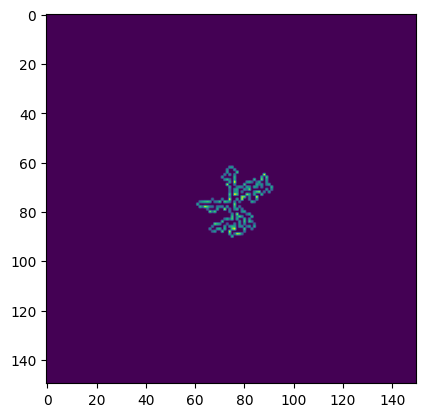

In [6]:
model.eval()
output = F.softmax(model(X_batch), dim=1)
output = output.detach().cpu().numpy()
plt.imshow(output[0].reshape(150, 150));

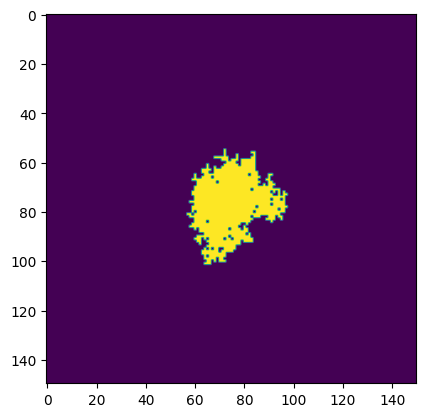

In [13]:
n = 150
grid = np.zeros((1, 1, n,n))
grid[0, 0, n//2, n//2] = 1

for i in range(1000):
    input = torch.tensor(grid, dtype=torch.float32).to(device)
    output = model(input)
    output = F.softmax(output, dim=1)
    output = output.detach().cpu().numpy()
    idx = np.random.choice(n*n, p=output[0].reshape(n*n))
    grid[0, 0, idx // n, idx % n] = 1

plt.imshow(grid[0, 0]);